<h3 text-align:center>Projet 2 : Système de recommandation d’images basé sur les préférences utilisateur</h3>
Matricule : 16MK292

Nom complet : MUNUNGA KAWIKA Dieudonné

Promotion : M1 DS

### Étape 1 : Collecte de données

In [6]:
import os
import requests
from PIL import Image
import exifread
import json
from io import BytesIO

# -------------------------
# 1. Préparation des dossiers
# -------------------------
os.makedirs('images', exist_ok=True)
os.makedirs('logs', exist_ok=True)

# -------------------------
# 2. Téléchargement de 300 images libres
# -------------------------
image_urls = [f"https://picsum.photos/400/300?random={i}" for i in range(300)]

for idx, url in enumerate(image_urls):
    try:
        response = requests.get(url, timeout=10)
        filename = f'images/image_{idx+1:03d}.jpg'
        with open(filename, 'wb') as f:
            f.write(response.content)
        print(f"Téléchargé : {filename}")
    except Exception as e:
        print(f"Erreur téléchargement image {idx+1}: {e}")

# -------------------------
# 3. Extraction des métadonnées et sauvegarde
# -------------------------

metadata_list = []
erreurs_exif = []

for image_file in os.listdir('images'):
    image_path = os.path.join('images', image_file)
    
    try:
        # Lecture PIL
        with Image.open(image_path) as img:
            width, height = img.size
            format_img = img.format

            # Orientation
            if width > height:
                orientation = "Paysage"
            elif width < height:
                orientation = "Portrait"
            else:
                orientation = "Carré"

        # Lecture EXIF
        with open(image_path, 'rb') as f:
            tags = exifread.process_file(f, details=False)

        # Extraction simplifiée des EXIF
        exif_data = {
            "DateTimeOriginal": str(tags.get("EXIF DateTimeOriginal", "Inconnu")),
            "Make": str(tags.get("Image Make", "Inconnu")),
            "Model": str(tags.get("Image Model", "Inconnu")),
            "Software": str(tags.get("Image Software", "Inconnu")),
            "Orientation": str(tags.get("Image Orientation", "Inconnu"))
        }

        # Vérification si les EXIF sont vraiment présents
        if len(tags) == 0:
            erreurs_exif.append(image_file)

        # Compilation des métadonnées
        metadata = {
            "filename": image_file,
            "width": width,
            "height": height,
            "format": format_img,
            "orientation": orientation,
            "exif": exif_data
        }

        metadata_list.append(metadata)
    
    except Exception as e:
        print(f"Erreur sur {image_file}: {e}")
        erreurs_exif.append(image_file)

# Sauvegarde JSON des métadonnées
with open("images/metadata.json", "w", encoding='utf-8') as jsonfile:
    json.dump(metadata_list, jsonfile, ensure_ascii=False, indent=4)

# Sauvegarde des erreurs
with open("logs/erreurs_exif.txt", "w") as logfile:
    logfile.write("Images sans EXIF ou erreurs :\n")
    for img in erreurs_exif:
        logfile.write(img + "\n")

print("\n Collecte terminée.")
print(f" Métadonnées enregistrées dans images/metadata.json")
print(f" Rapport d'erreurs généré dans logs/erreurs_exif.txt")


Téléchargé : images/image_001.jpg
Téléchargé : images/image_002.jpg
Téléchargé : images/image_003.jpg
Téléchargé : images/image_004.jpg
Téléchargé : images/image_005.jpg
Téléchargé : images/image_006.jpg
Téléchargé : images/image_007.jpg
Téléchargé : images/image_008.jpg
Téléchargé : images/image_009.jpg
Téléchargé : images/image_010.jpg
Téléchargé : images/image_011.jpg
Téléchargé : images/image_012.jpg
Téléchargé : images/image_013.jpg
Téléchargé : images/image_014.jpg
Téléchargé : images/image_015.jpg
Téléchargé : images/image_016.jpg
Téléchargé : images/image_017.jpg
Téléchargé : images/image_018.jpg
Téléchargé : images/image_019.jpg
Téléchargé : images/image_020.jpg
Téléchargé : images/image_021.jpg
Téléchargé : images/image_022.jpg
Téléchargé : images/image_023.jpg
Téléchargé : images/image_024.jpg
Téléchargé : images/image_025.jpg
Téléchargé : images/image_026.jpg
Téléchargé : images/image_027.jpg
Téléchargé : images/image_028.jpg
Téléchargé : images/image_029.jpg
Téléchargé : i

### Étape 2 : Annotation automatique

In [8]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt
import random

# Fonction d'extraction des couleurs dominantes
def extract_colors(image_path, k=3):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.reshape((image.shape[0] * image.shape[1], 3))

    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(image)
    colors = kmeans.cluster_centers_.astype(int)

    hex_colors = ['#{:02x}{:02x}{:02x}'.format(*color) for color in colors]
    return hex_colors

# Traitement de toutes les images
metadata_file = "images/metadata.json"
with open(metadata_file, "r", encoding='utf-8') as f:
    metadata_list = json.load(f)

for image in metadata_list:
    img_path = os.path.join("images", image["filename"])
    try:
        dominant_colors = extract_colors(img_path)
        image["colors"] = dominant_colors
        print(f"Image {image['filename']} : couleurs {dominant_colors}")
    except Exception as e:
        print(f"Erreur pour {image['filename']} : {e}")

# Sauvegarde du fichier enrichi
with open("images/metadata_enriched.json", "w", encoding='utf-8') as f:
    json.dump(metadata_list, f, ensure_ascii=False, indent=4)

print("Extraction des couleurs terminée")

# Fonction pour annoter les métadonnées avec les couleurs dominantes
def annotate_metadata(metadata_list):
    for metadata in metadata_list:
        file_path = os.path.join("images", metadata["filename"])
        metadata["dominant_colors"] = extract_colors(file_path, k=3)
    with open("images/metadata_annotated.json", "w", encoding="utf-8") as f:
        json.dump(metadata_list, f, ensure_ascii=False, indent=2)
    print("Couleurs dominantes ajoutées.")
    return metadata_list

# Fonction pour ajouter des tags simulés
def add_simulated_tags(metadata_list):
    possible_tags = ["#chat", "#chien", "#fleur", "#plage", "#ciel", "#ville", "#nature", "#forêt"]
    for metadata in metadata_list:
        metadata["tags"] = random.sample(possible_tags, 3)
    with open("images/metadata_annotated.json", "w", encoding="utf-8") as f:
        json.dump(metadata_list, f, ensure_ascii=False, indent=2)
    print("Tags simulés ajoutés.")
    
# Utilisation directe dans le notebook
metadata_list = annotate_metadata(metadata_list)
add_simulated_tags(metadata_list)

Image image_001.jpg : couleurs ['#2d351c', '#bcd4dc', '#777163']
Image image_002.jpg : couleurs ['#aaa8a7', '#5b5857', '#22201f']
Image image_003.jpg : couleurs ['#241413', '#c2dff4', '#a17159']
Image image_004.jpg : couleurs ['#737062', '#c8c6a2', '#27213b']
Image image_005.jpg : couleurs ['#49515a', '#d1deee', '#8695a7']
Image image_006.jpg : couleurs ['#7f818a', '#e7e6e5', '#33333e']
Image image_007.jpg : couleurs ['#a98374', '#dbe2e4', '#670f0f']
Image image_008.jpg : couleurs ['#4e3837', '#c1b6b7', '#85666f']
Image image_009.jpg : couleurs ['#7793ac', '#050a16', '#2c415a']
Image image_010.jpg : couleurs ['#2f1f1a', '#ead8b8', '#b27640']
Image image_011.jpg : couleurs ['#191818', '#dfdfe0', '#595d62']
Image image_012.jpg : couleurs ['#afa897', '#171917', '#636358']
Image image_013.jpg : couleurs ['#202035', '#2f2f4e', '#201b1a']
Image image_014.jpg : couleurs ['#4b495c', '#f2823c', '#dad8de']
Image image_015.jpg : couleurs ['#5a96dc', '#0921b6', '#050e35']
Image image_016.jpg : cou

### Étape 3 : Analyse des utilisateurs

In [9]:
# Charger les métadonnées des images annotées (couleurs + tags)
def load_metadata(filepath="images/metadata_annotated.json"):
    with open(filepath, "r", encoding="utf-8") as f:
        return json.load(f)

# Simuler des profils utilisateurs avec préférences déduites des images aimées
def generate_user_profiles(metadata_list, n_users=5):
    users = {}
    for user_id in range(1, n_users + 1):
        liked_images = random.sample(metadata_list, 3)

        # Extraire les préférences
        preferred_tags = list({tag for img in liked_images for tag in img.get('tags', [])})
        preferred_colors = [img.get('dominant_colors', []) for img in liked_images]
        orientations = [img.get('orientation') for img in liked_images if 'orientation' in img]

        users[f"user_{user_id}"] = {
            "liked_images": [img['filename'] for img in liked_images],
            "preferred_tags": preferred_tags,
            "preferred_orientations": list(set(orientations)),
            "preferred_colors": preferred_colors
        }
    return users

# Sauvegarder les profils utilisateurs dans un fichier JSON
def save_user_profiles(users, filepath="user_profiles.json"):
    with open(filepath, "w") as f:
        json.dump(users, f, indent=2)
    print(f"Profils utilisateurs sauvegardés dans '{filepath}'.")


metadata_list = load_metadata("images/metadata_annotated.json")
user_profiles = generate_user_profiles(metadata_list, n_users=5)
save_user_profiles(user_profiles)

Profils utilisateurs sauvegardés dans 'user_profiles.json'.


### Étape 4 : Visualisation

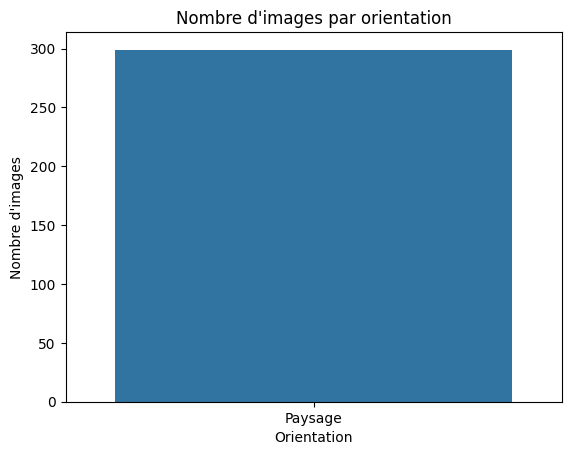

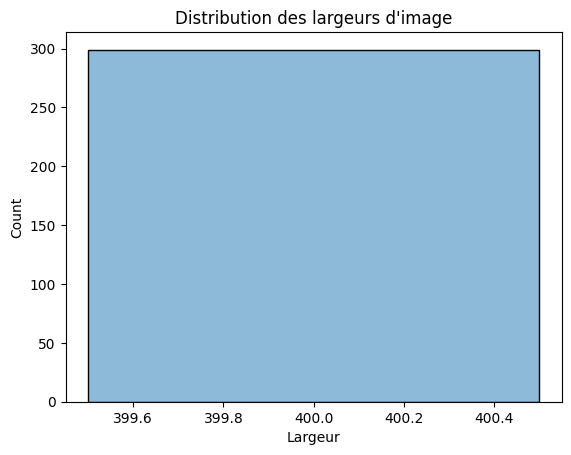

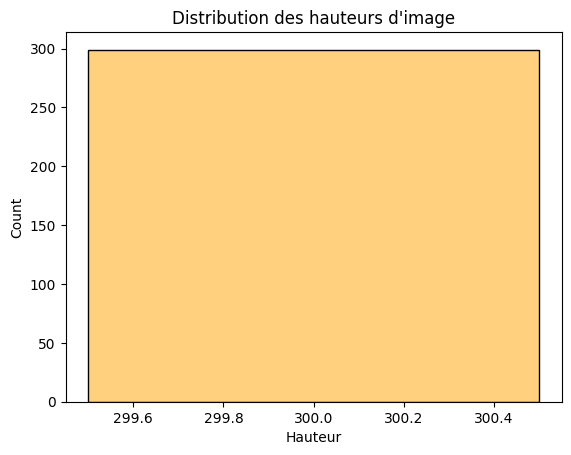

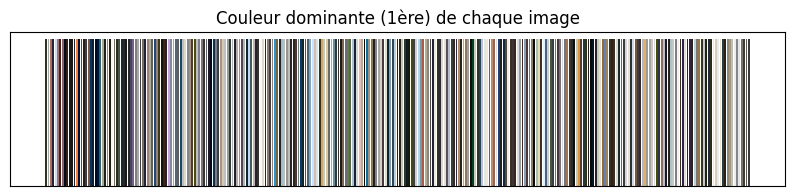

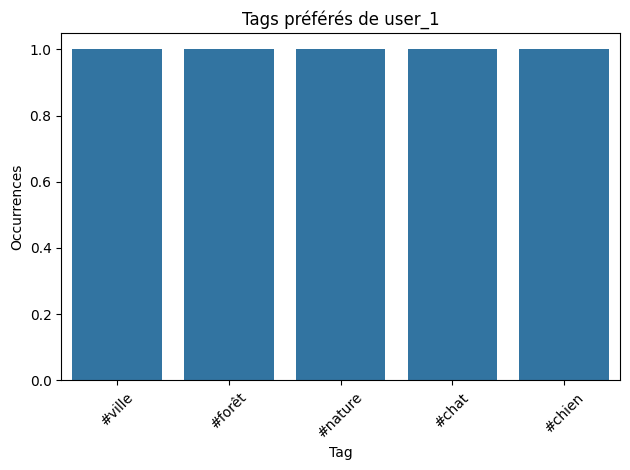

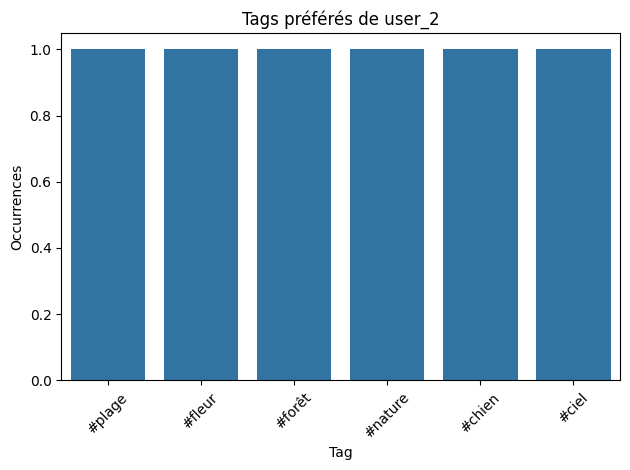

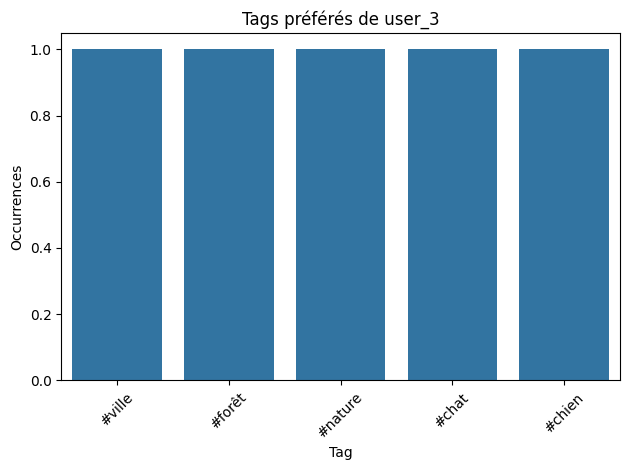

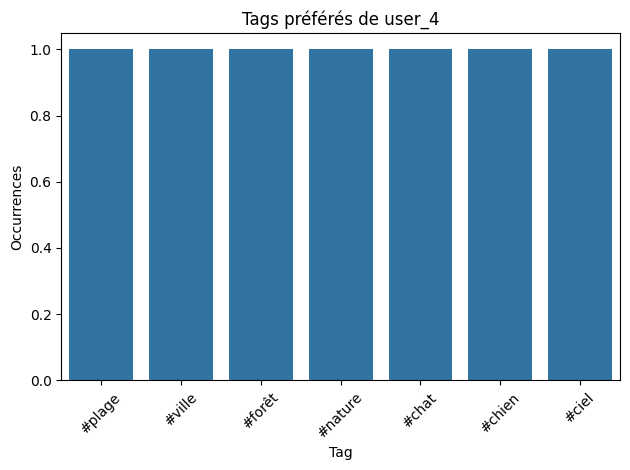

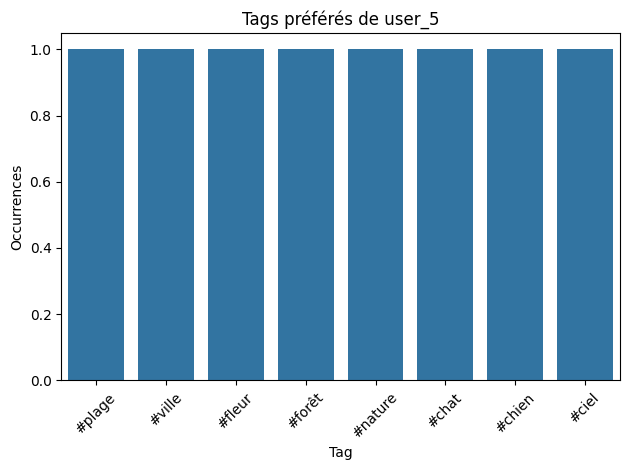

In [13]:
import seaborn as sns
import pandas as pd

# Charger les données
with open("images/metadata_annotated.json", "r") as f:
    metadata_list = json.load(f)

with open("user_profiles.json", "r") as f:
    user_profiles = json.load(f)

# --------------------------------------
# Visualisation des images (métadonnées)
# --------------------------------------

# 1. Distribution des orientations
def plot_orientations(metadata_list):
    orientations = [img.get("orientation") for img in metadata_list if "orientation" in img]
    sns.countplot(x=orientations)
    plt.title("Nombre d'images par orientation")
    plt.xlabel("Orientation")
    plt.ylabel("Nombre d'images")
    plt.show()

# 2. Distribution des tailles (largeur / hauteur)
def plot_image_sizes(metadata_list):
    sizes = [(img["width"], img["height"]) for img in metadata_list if "width" in img and "height" in img]
    widths, heights = zip(*sizes)
    df_sizes = pd.DataFrame({"Largeur": widths, "Hauteur": heights})

    sns.histplot(df_sizes["Largeur"], kde=True)
    plt.title("Distribution des largeurs d'image")
    plt.show()

    sns.histplot(df_sizes["Hauteur"], kde=True, color="orange")
    plt.title("Distribution des hauteurs d'image")
    plt.show()

# 3. Couleurs dominantes (1ère couleur de chaque image)
def plot_dominant_colors(metadata_list):
    dominant_colors = [img["dominant_colors"][0] for img in metadata_list if img.get("dominant_colors")]
    hex_colors = dominant_colors  # Already in hex format

    plt.figure(figsize=(10, 2))
    plt.bar(range(len(hex_colors)), [1]*len(hex_colors), color=hex_colors)
    plt.title("Couleur dominante (1ère) de chaque image")
    plt.yticks([])
    plt.xticks([])
    plt.show()

# --------------------------------------
# Visualisation des profils utilisateurs
# --------------------------------------

def plot_user_tags(user_profiles):
    for user_id, profile in user_profiles.items():
        tags = profile.get("preferred_tags", [])
        if tags:
            plt.figure()
            sns.countplot(x=tags)
            plt.title(f"Tags préférés de {user_id}")
            plt.xlabel("Tag")
            plt.ylabel("Occurrences")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

# --------------------------------------
# Exécution globale des visualisations
# --------------------------------------

if __name__ == "__main__":
    plot_orientations(metadata_list)
    plot_image_sizes(metadata_list)
    plot_dominant_colors(metadata_list)
    plot_user_tags(user_profiles)


### Étape 5 : Système de recommandation

In [14]:
# --------------------------------------
# Chargement des données
# --------------------------------------

def load_data():
    with open("metadata_annotated.json", "r") as f:
        metadata_list = json.load(f)
    
    with open("user_profiles.json", "r") as f:
        user_profiles = json.load(f)
    
    return metadata_list, user_profiles

# --------------------------------------
# Fonction de similarité par tags
# --------------------------------------

def calculate_similarity(image, user_tags):
    image_tags = set(image.get("tags", []))
    common_tags = image_tags.intersection(user_tags)
    return len(common_tags)

# --------------------------------------
# Fonction de recommandation par contenu
# --------------------------------------

def recommend_images(user_profile, all_images, top_n=3):
    user_tags = set(user_profile.get("preferred_tags", []))
    liked_files = set(user_profile.get("liked_images", []))

    candidates = []
    for image in all_images:
        if image["filename"] not in liked_files:
            score = calculate_similarity(image, user_tags)
            candidates.append((image["filename"], score))
    
    candidates.sort(key=lambda x: x[1], reverse=True)
    return candidates[:top_n]

# --------------------------------------
# Exécution globale pour tous les utilisateurs
# --------------------------------------

def generate_recommendations(metadata_list, user_profiles, top_n=3):
    for user_id, profile in user_profiles.items():
        recs = recommend_images(profile, metadata_list, top_n)
        print(f"\nRecommandations pour {user_id} :")
        for rec in recs:
            print(f"  Image: {rec[0]} | Score: {rec[1]}")

# --------------------------------------
# Lancement principal du module
# --------------------------------------

# Utilisation directe des variables déjà chargées dans le notebook
generate_recommendations(metadata_list, user_profiles, top_n=3)



Recommandations pour user_1 :
  Image: image_020.jpg | Score: 3
  Image: image_039.jpg | Score: 3
  Image: image_043.jpg | Score: 3

Recommandations pour user_2 :
  Image: image_018.jpg | Score: 3
  Image: image_028.jpg | Score: 3
  Image: image_036.jpg | Score: 3

Recommandations pour user_3 :
  Image: image_020.jpg | Score: 3
  Image: image_039.jpg | Score: 3
  Image: image_043.jpg | Score: 3

Recommandations pour user_4 :
  Image: image_003.jpg | Score: 3
  Image: image_004.jpg | Score: 3
  Image: image_005.jpg | Score: 3

Recommandations pour user_5 :
  Image: image_003.jpg | Score: 3
  Image: image_004.jpg | Score: 3
  Image: image_005.jpg | Score: 3


### Étape 6 : Tests fonctionnels

In [15]:
# --------------------------------------
# Tests de présence des fichiers
# --------------------------------------

def check_files():
    required_files = [
        "images/metadata.json",
        "images/metadata_annotated.json",
        "user_profiles.json"
    ]
    for file in required_files:
        assert os.path.exists(file), f"Le fichier {file} est manquant."
    print("\n Tous les fichiers nécessaires sont présents.")

# --------------------------------------
# Tests de contenu des fichiers
# --------------------------------------

def check_metadata_content():
    with open("images/metadata_annotated.json", "r") as f:
        metadata_list = json.load(f)

    assert len(metadata_list) > 0, "Le fichier metadata_annotated.json est vide."

    for img in metadata_list:
        assert "tags" in img and len(img["tags"]) > 0, "Tags manquants sur une image."
        assert "dominant_colors" in img and len(img["dominant_colors"]) > 0, "Couleurs dominantes manquantes."
    
    print("\n Les métadonnées des images sont valides.")
    return metadata_list

def check_user_profiles():
    with open("user_profiles.json", "r") as f:
        user_profiles = json.load(f)

    assert len(user_profiles) > 0, "Le fichier user_profiles.json est vide."
    print("\n Les profils utilisateurs sont valides.")
    return user_profiles

# --------------------------------------
# Test du système de recommandation
# --------------------------------------

def calculate_similarity(image, user_tags):
    image_tags = set(image.get("tags", []))
    common_tags = image_tags.intersection(user_tags)
    return len(common_tags)

def recommend_images(user_profile, all_images, top_n=3):
    user_tags = set(user_profile.get("preferred_tags", []))
    liked_files = set(user_profile.get("liked_images", []))

    candidates = []
    for image in all_images:
        if image["filename"] not in liked_files:
            score = calculate_similarity(image, user_tags)
            candidates.append((image["filename"], score))
    
    candidates.sort(key=lambda x: x[1], reverse=True)
    return candidates[:top_n]

def test_recommendation(metadata_list, user_profiles):
    example_user = list(user_profiles.values())[0]
    recs = recommend_images(example_user, metadata_list, top_n=3)
    assert len(recs) > 0, "Aucune recommandation générée."
    print("\n Recommandations générées avec succès.")

# --------------------------------------
# Exécution globale des tests
# --------------------------------------

def run_all_tests():
    check_files()
    metadata_list = check_metadata_content()
    user_profiles = check_user_profiles()
    test_recommendation(metadata_list, user_profiles)
    print("\n Tous les tests sont passés avec succès !")

if __name__ == "__main__":
    run_all_tests()



 Tous les fichiers nécessaires sont présents.

 Les métadonnées des images sont valides.

 Les profils utilisateurs sont valides.

 Recommandations générées avec succès.

 Tous les tests sont passés avec succès !
